# Questions

How to make search experience easier through data?

- Where are the cheapest options located? (Where to look)
- Can we pre-segment listings by their characteristics? (Offer Groups of listings)
- Are the location prices and cluster prices associated to market concentration? (Avoid skewed prices)
- What are usual amenities that the customer should expect from listings in Rio? (Set expectations)

In [1]:
# Wrangling
import pandas as pd
import numpy as np

# Modelling
from kmodes.kmodes import KModes

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Text
import unidecode
import re

In [2]:
# Setting a bigger standard figure size
sns.set(rc={"figure.figsize":(15, 10)})

In [3]:
df = pd.read_csv('data/listings.csv.gz', compression='gzip')

In [4]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [5]:
with pd.option_context('display.max_columns',None):
    display(df.head())

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,53344884,https://www.airbnb.com/rooms/53344884,20220921172238,2022-09-22,city scrape,Suntuoso apartamento em Copacabana posto 6,suntuoso apartamento de frente para o mar <br ...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,431412286,https://www.airbnb.com/users/show/431412286,Carlos Henrique,2021-11-11,NaN,NaN,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/f4bec...,https://a0.muscache.com/im/pictures/user/f4bec...,NaN,10.0,10.0,"['email', 'phone']",t,t,NaN,Copacabana,NaN,-22.98299,-43.18904,Entire condo,Entire home/apt,6,NaN,4.5 baths,3.0,5.0,"[""Air conditioning"", ""Washer"", ""Security camer...","$3,500.00",3,365,3,3,365,365,3.0,365.0,NaN,t,30,60,90,365,2022-09-22,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,10,8,2,0,NaN
1,7801456,https://www.airbnb.com/rooms/7801456,20220921172238,2022-09-22,city scrape,Ipanema Vieira Souto - Linda Vista,Flat luxuoso com a melhor localização do Rio d...,"Ipanema é considerado o berço do rio, cheio de...",https://a0.muscache.com/pictures/99276394/dc9c...,40650139,https://www.airbnb.com/users/show/40650139,Carlos Alberto,2015-08-05,"Rio de Janeiro, Brazil","22 anos, Brasileiro, Solteiro, residencia fixa...",a few days or more,13%,100%,f,https://a0.muscache.com/im/users/40650139/prof...,https://a0.muscache.com/im/users/40650139/prof...,Ipanema,6.0,6.0,"['email', 'phone']",t,t,"Rio de Janeiro, Brazil",Ipanema,NaN,-22.98723,-43.20452,Entire serviced apartment,Entire home/apt,4,NaN,2 baths,2.0,3.0,"[""Cable TV"", ""Air conditioning"", ""Fire extingu...","$5,000.00",2,900,2,2,900,900,2.0,900.0,NaN,t,30,60,90,365,2022-09-22,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,5,5,0,0,NaN
2,14333905,https://www.airbnb.com/rooms/14333905,20220921172238,2022-09-22,city scrape,Casa compartilhada,"A 15 min. do complexo esportivo de Deodoro, Ca...",NaN,https://a0.muscache.com/pictures/15235501-16c4...,87749071,https://www.airbnb.com/users/show/87749071,Lindenberg,2016-08-03,"Rio de Janeiro, Brazil",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/409ec...,https://a0.muscache.com/im/pictures/user/409ec...,NaN,1.0,1.0,"['email', 'phone']",t,f,NaN,Pavuna,NaN,-22.80869,-43.38642,Entire home,Entire home/apt,12,NaN,1 bath,2.0,4.0,"[""Cable TV"", ""Air conditioning"", ""Hair dryer"",...",$681.00,1,1125,1,1,1125,1125,1.0,1125.0,NaN,t,30,60,90,365,2022-09-22,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,1,1,0,0,NaN
3,44708736,https://www.airbnb.com/rooms/44708736,20220921172238,2022-09-22,city scrape,Aluguel de Lancha no Rio de Janeiro,Iate Intermarine 440 Full Gold c/ Fly p/ até 1...,A Marina da Glória fica no bairro do Flamengo ...,https://a0.muscache.com/pictures/210e9

# Sanity Checks

## Empty Values

In [6]:
# Proportion of nan values

col_na_proportion = df.isna().mean()

In [7]:
col_na_proportion[col_na_proportion > 0.1].round(3) # Arbitrary minimum NA boundary of 10% of rows

neighborhood_overview           0.473
host_location                   0.182
host_about                      0.515
host_response_time              0.133
host_response_rate              0.133
host_acceptance_rate            0.134
host_neighbourhood              0.407
neighbourhood                   0.473
neighbourhood_group_cleansed    1.000
bathrooms                       1.000
calendar_updated                1.000
first_review                    0.266
last_review                     0.266
review_scores_rating            0.266
review_scores_accuracy          0.274
review_scores_cleanliness       0.274
review_scores_checkin           0.274
review_scores_communication     0.274
review_scores_location          0.274
review_scores_value             0.274
license                         1.000
reviews_per_month               0.266
dtype: float64

- Some columns are complely empty
- About half of the listings don't have any description about the host
- Approx. 1 out of 4 listings don't have a review

- Bathrooms columns was actually replaced with bathrooms_text

## Subsetting to relevant features

In [8]:
# Subsetting to columns that will be relevant for us to work with
# Ignoring relevant columns that are completely empty (bathrooms)
subset_cols = ['id',
                'host_id',
                'host_total_listings_count',
                'listing_url',
                'last_scraped',
                'source',
                'name',
                'description',
                'neighbourhood_cleansed',
                'property_type',
                'room_type',
                'accommodates',
                'bathrooms_text',
                'bedrooms',
                'beds',
                'amenities',
                'price',
                'minimum_nights']

In [9]:
df_subset = df[subset_cols].copy() # Generating a copy to avoid object reference problems when creating new cols

In [10]:
df_subset.isna().mean()

id                           0.000000
host_id                      0.000000
host_total_listings_count    0.000190
listing_url                  0.000000
last_scraped                 0.000000
source                       0.000000
name                         0.000721
description                  0.031366
neighbourhood_cleansed       0.000000
property_type                0.000000
room_type                    0.000000
accommodates                 0.000000
bathrooms_text               0.001896
bedrooms                     0.049723
beds                         0.008951
amenities                    0.000000
price                        0.000000
minimum_nights               0.000000
dtype: float64

## Subset - Type handling

In [11]:
df_subset.dtypes

id                             int64
host_id                        int64
host_total_listings_count    float64
listing_url                   object
last_scraped                  object
source                        object
name                          object
description                   object
neighbourhood_cleansed        object
property_type                 object
room_type                     object
accommodates                   int64
bathrooms_text                object
bedrooms                     float64
beds                         float64
amenities                     object
price                         object
minimum_nights                 int64
dtype: object

### Dates

In [12]:
# Handling scraped date
df_subset['last_scraped'] = pd.to_datetime(df_subset['last_scraped'], yearfirst=True)

In [13]:
# Check if dataset contains old entries - They might not be relevant
df_subset['last_scraped'].value_counts()

2022-09-22    20849
2022-09-21     5462
2022-09-23       54
2022-10-02        1
Name: last_scraped, dtype: int64

All dates on the scrape are recent enough

### Prices

In [14]:
df_subset.price.head()

0    $3,500.00
1    $5,000.00
2      $681.00
3    $8,999.00
4      $500.00
Name: price, dtype: object

In [15]:
# Do all prices start with '$'?
print(df_subset['price'].shape[0] == df_subset['price'].str.startswith('$').sum())

True


In [16]:
# Removing the '$'
df_subset['price'] = df_subset['price'].str[1:]

# Removing thousands comma
df_subset['price'] = df_subset['price'].str.replace(',','', regex=True)

# Turning price into float 
df_subset['price'] = df_subset['price'].astype(float)

### Amenities

In [17]:
df_subset['amenities'].head()

0    ["Air conditioning", "Washer", "Security camer...
1    ["Cable TV", "Air conditioning", "Fire extingu...
2    ["Cable TV", "Air conditioning", "Hair dryer",...
3    ["Single level home", "Wifi \u2013 30 Mbps", "...
4    ["Air conditioning", "First aid kit", "Iron", ...
Name: amenities, dtype: object

In [18]:
# Are amenities strings?
(df_subset['amenities'].apply(type) == str).all()

True

Amenities are actually strings instead of lists. This needs fixing.\
Also, since it is a whole string, the whitespaces before the quotes will stay there. They need to be fixed too.\
To fix the whitespaces I will be using a function, but it could be done via RegEx as well.\
Also, some not parsed unidecode characters get into the dataset. They will be removed since they probably won't be word characters

In [19]:
def strip_tokens(token_list):

    return [token.strip() for token in token_list]

def replace_unidecode(token_list):

    ''' Replaces non-parsed unidecode chars with single Whitespace.
        If simply replaced by empty strings, will generate a double whitespace
        '''

    return [re.sub(r'\s+', ' ', re.sub(r'\\u\d+','', token)) for token in token_list]

In [20]:
# The Brackets and quotes will break a simple split function. They need to be treated beforehand.
df_subset['amenities'] = df_subset['amenities'].str.replace('\[|\]|\"','', regex = True)\
                                                .str.split(',')\
                                                .apply(strip_tokens)\
                                                .apply(replace_unidecode)

In [21]:
display(df_subset['amenities'].head())

display(df_subset['amenities'][0]) # Example

0    [Air conditioning, Washer, Security cameras on...
1    [Cable TV, Air conditioning, Fire extinguisher...
2    [Cable TV, Air conditioning, Hair dryer, Iron,...
3    [Single level home, Wifi 30 Mbps, Dedicated wo...
4    [Air conditioning, First aid kit, Iron, Essent...
Name: amenities, dtype: object

['Air conditioning',
 'Washer',
 'Security cameras on property',
 'Wifi',
 'Long term stays allowed',
 'Kitchen',
 'TV']

### Bathrooms

In [22]:
df_subset.bathrooms_text

0            4.5 baths
1              2 baths
2               1 bath
3              2 baths
4               1 bath
             ...      
26361    1 shared bath
26362           1 bath
26363           1 bath
26364           1 bath
26365           1 bath
Name: bathrooms_text, Length: 26366, dtype: object

In [23]:
print('Entries that contain "bath":',df_subset[df_subset['bathrooms_text'].str.contains(r'bath[s]?', na = False)].shape[0])

print('Total Entries:',df_subset.shape[0])

Entries that contain "bath": 26316
Total Entries: 26366


There are 50 entries that don't contain the any word with 'bath' in it

In [24]:
df_subset[~df_subset['bathrooms_text'].str.contains(r'bath[s]?', na = False)]['bathrooms_text'].isna().sum()

50

The different entries are empty are because they are NaN values

In [25]:
df_subset[~df_subset['bathrooms_text'].str.contains(r'bath[s]?', na = False)][['name','description']].sample(10, random_state=123)

,name,description
479,Praia da Macumba Recreio,"<b>The space</b><br />Apartameno pequeno,1 Qto..."
603,Cozy room @ Copacabana - Posto 06,<b>The space</b><br />Excellent apartment near...
2056,Maracana - apartamento a 200 metros,Excelente apartamento a 200 metros do MARACANÃ...
19656,Mansão INCRÍVEL no meio da natureza para EVENTOS,NaN
661,ótimo Quarto em Santa Teresa - RJ,<b>The space</b><br />Casa ampla em Santa Tere...
89,Apartamento Moderno e confortavel,"Seja bem vindo a esse apartamento moderno, con..."
14651,Américas Copacabana Hotel,NaN
600,Vinicius,"tarifa baixa temporada, mínimo 5 noites<br /><..."
869,Ipanema 602,"<b>The space</b><br />linen not included, on r..."
348,BAND NEW APT COPACABANA,<b>The space</b><br />APT JUST RENOVATED! ALL ...


From the descriptions, it doesn't look like these are listings that don't have bathrooms. Imputing with some value might be more realistic.\
Also, there are not many listings without the number of bathrooms. It shouldn't impact us much

After some inspections there are some key tokens that will be removed, for simplicity:

- Bath(s)
- Shared
- Private

In [26]:
df_subset['bathrooms_text'].str.contains('shared').sum()

3156

In [27]:
df_subset['bathrooms_text'].str.contains('private').sum()

1727

In [28]:
# Removing the words
df_subset['bathrooms_text'] = df_subset['bathrooms_text'].str.replace(r'bath[s]?|shared|private','',case = False,regex = True)\
                                                            .str.strip()

In [29]:
# Looking for other tokens
df_subset[(df_subset['bathrooms_text'].notnull()) & (df_subset['bathrooms_text'].str.contains(r'[A-Za-z]+', regex = True))]['bathrooms_text'].unique()

array(['half-', 'Half-'], dtype=object)

In [30]:
# Replacing half with 0.5
df_subset['bathrooms_text'] = df_subset['bathrooms_text'].str.replace(r'half-','0.5',case = False,regex = True)\
                                                            .str.strip()

In [31]:
df_subset[(df_subset['bathrooms_text'].notnull()) & (df_subset['bathrooms_text'].str.contains(r'[A-Za-z]+', regex = True))]['bathrooms_text'].unique()

array([], dtype=object)

In [32]:
df_subset['bathrooms_text'] = df_subset['bathrooms_text'].astype(float)

## NaNs

In [33]:
# Dropping listings that don't have bathroom, bedrooms or beds information
df_subset.dropna(subset = ['bathrooms_text','bedrooms','beds'], inplace = True)

# City Zones

Rio is a big city. To make the geographical splits easier on the market concentration phase, the neighbouroods will we grouped according to their city-zoning.\
For simplicity this data will be extracted from [Wikipedia](https://pt.wikipedia.org/wiki/Lista_de_bairros_da_cidade_do_Rio_de_Janeiro)

Note that the neighbourhood_group that came with the dataset is totally empty

In [34]:
link = 'https://pt.wikipedia.org/wiki/Lista_de_bairros_da_cidade_do_Rio_de_Janeiro'

In [35]:
# Reading data from wikipedia
tables = pd.read_html(link,match = 'Bairros oficiais')

In [36]:
# We should only match a single table
len(tables)

1

In [37]:
# Getting the table to a DataFrame - copying to avoid changes to the reference!
zones = tables[0].copy()

In [38]:
zones.head()

,0,1,2,3
0,Bairros oficiais,Bairros oficiais,Bairros oficiais,Bairros oficiais
1,Zona,Subprefeitura(nº de bairros),Bairros[6],Imagens
2,Central,Centro Histórico e Zona Portuária (16)[7][8],Bairro Imperial de São Cristóvão • Benfica • C...,NaN
3,Sul,Zona Sul (18)[9],Botafogo • Catete • Copacabana • Cosme Velho •...,NaN
4,Oeste,Barra da Tijuca e Baixada de Jacarepaguá (20),Anil • Barra da Tijuca • Camorim • Cidade de D...,NaN


In [39]:
# Dropping the first row.
zones.drop(0, inplace = True)

# Passing the new first row as the column names
zones.columns = zones.iloc[0]

# Dropping the names from the table
zones.drop(1, inplace = True)

# Resetting index since we've dropped two rows
zones.reset_index(drop = True, inplace = True)

# Unassigning a name to the columns
zones.columns.name  = None

# Renaming relevant columns
zones.rename(columns = {'Zona':'zone', 'Bairros[6]':'neighbourhood'}, inplace = True)

# Fetching relevant columns
zones = zones[['zone','neighbourhood']].copy()

In [40]:
zones.head()

,zone,neighbourhood
0,Central,Bairro Imperial de São Cristóvão • Benfica • C...
1,Sul,Botafogo • Catete • Copacabana • Cosme Velho •...
2,Oeste,Anil • Barra da Tijuca • Camorim • Cidade de D...
3,Oeste,Bangu • Campo dos Afonsos • Deodoro • Gericinó...
4,Oeste,Barra de Guaratiba • Campo Grande • Cosmos • G...


In [41]:
zones.zone.unique()

array(['Central', 'Sul', 'Oeste', 'Norte'], dtype=object)

In [42]:
# Mapping zones from portuguese to english
zone_en_map = {'Sul':'South','Oeste':'West','Norte':'North','Central':'Central'}

zones.zone = zones.zone.map(zone_en_map)

zones.zone.unique()

array(['Central', 'South', 'West', 'North'], dtype=object)

In [43]:
# Removing the dot
zones['neighbourhood'] = zones['neighbourhood'].str.split('•')

# Turning lists into long DF
zones = zones.explode('neighbourhood')

In [44]:
# Checking for trailing whitespaces
zones.head().values

array([['Central', 'Bairro Imperial de São Cristóvão '],
       ['Central', ' Benfica '],
       ['Central', ' Caju '],
       ['Central', ' Catumbi '],
       ['Central', ' Centro ']], dtype=object)

We still need to fix the trailing whitespaces and remove special characters like 'ó' or 'ç'. This will make joining the data easier up ahead

In [45]:
# Removing special characters
zones['neighbourhood'] = zones['neighbourhood'].apply(unidecode.unidecode)

# Removing trailing whitespaces
zones['neighbourhood'] = zones['neighbourhood'].str.strip()

# Lowercasing all values
zones['neighbourhood'] = zones['neighbourhood'].str.lower()

In [46]:
zones.head()

,zone,neighbourhood
0,Central,bairro imperial de sao cristovao
0,Central,benfica
0,Central,caju
0,Central,catumbi
0,Central,centro


### Joining the data

Also prepping the table data to merge to the zoning data

In [47]:
# Removing special characters
df_subset['neighbourhood_cleansed'] = df_subset['neighbourhood_cleansed'].apply(unidecode.unidecode)

# Lowercasing all values
df_subset['neighbourhood_cleansed'] = df_subset['neighbourhood_cleansed'].str.lower()

In [48]:
df_subset['neighbourhood_cleansed'].head()

0    copacabana
1       ipanema
2        pavuna
3        gloria
4        pavuna
Name: neighbourhood_cleansed, dtype: object

In [49]:
# Merging left to avoid losing data in case match is not perfect
df_subset = df_subset.merge(zones, left_on = 'neighbourhood_cleansed', right_on = 'neighbourhood', indicator = True, how = 'left')

In [50]:
# Checking if some data wasn't found
df_subset._merge.value_counts()

both          24605
left_only       213
right_only        0
Name: _merge, dtype: int64

In [51]:
# Which neighbourhoods didn't match?
df_subset[df_subset['_merge'] == 'left_only']['neighbourhood_cleansed'].unique()

array(['freguesia (ilha)', 'sao cristovao', 'freguesia (jacarepagua)',
       'osvaldo cruz'], dtype=object)

Some names didn't match, but that's ok. We can fix them by hand.

freguesia (ilha) &rarr;  North\
sao cristovao &rarr; Central\
freguesia (jacarepagua) &rarr; West\
osvaldo cruz &rarr; North\
mare &rarr; North

In [52]:
# Fixing neighbourhoods to match them with their respective zone
choices = [df_subset['neighbourhood_cleansed'] == 'freguesia (ilha)',
            df_subset['neighbourhood_cleansed'] == 'sao cristovao',
            df_subset['neighbourhood_cleansed'] == 'freguesia (jacarepagua)',
            df_subset['neighbourhood_cleansed'] =='osvaldo cruz',
            df_subset['neighbourhood_cleansed'] =='mare']

options = ['North', 'Central', 'West','North','North']

df_subset['zone'] = np.select(choices, options,default = df_subset['zone'])

In [53]:
# Asserting all values were handled
df_subset['zone'].isna().sum()

0

In [54]:
# Dropping 
df_subset.drop(columns = ['neighbourhood','_merge'],inplace = True)

In [55]:
df_subset.head()

,id,host_id,host_total_listings_count,listing_url,last_scraped,source,name,description,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,zone
0,53344884,431412286,10.0,https://www.airbnb.com/rooms/53344884,2022-09-22,city scrape,Suntuoso apartamento em Copacabana posto 6,suntuoso apartamento de frente para o mar <br ...,copacabana,Entire condo,Entire home/apt,6,4.5,3.0,5.0,"[Air conditioning, Washer, Security cameras on...",3500.0,3,South
1,7801456,40650139,6.0,https://www.airbnb.com/rooms/7801456,2022-09-22,city scrape,Ipanema Vieira Souto - Linda Vista,Flat luxuoso com a melhor localização do Rio d...,ipanema,Entire serviced apartment,Entire home/apt,4,2.0,2.0,3.0,"[Cable TV, Air conditioning, Fire extinguisher...",5000.0,2,South
2,14333905,87749071,1.0,https://www.airbnb.com/rooms/14333905,2022-09-22,city scrape,Casa compartilhada,"A 15 min. do complexo esportivo de Deodoro, Ca...",pavuna,Entire home,Entire home/apt,12,1.0,2.0,4.0,"[Cable TV, Air conditioning, Hair dryer, Iron,...",681.0,1,North
3,44708736,97164727,4.0,https://www.airbnb.com/rooms/44708736,2022-09-22,city scrape,Aluguel de Lancha no Rio de Janeiro,Iate Intermarine 440 Full Gold c/ Fly p/ até 1...,gloria,Boat,Entire home/apt,12,2.0,2.0,3.0,"[Single level home, Wifi 30 Mbps, Dedicated wo...",8999.0,1,South
4,35351763,249666532,1.0,https://www.airbnb.com/rooms/35351763,2022-09-22,city scrape,Uma grande família,"Estou oferecendo minha casa ,minha família meu...",pavuna,Earthen home,Entire home/apt,1,1.0,2.0,3.0,"[Air conditioning, First aid kit, Iron, Essent...",500.0,1,North


# Price analysis

Price will be used throughout our questions, we should take a look at it specifically before using it

In [56]:
df_subset['price'].describe()

count     24818.000000
mean        800.696591
std        5382.310646
min          33.000000
25%         190.000000
50%         320.000000
75%         629.000000
max      590887.000000
Name: price, dtype: float64

There are clearly some weird prices. Let's take a look at daily prices that are higher than 10k. 
Let's also look at the zeros

## Values over 10k

<AxesSubplot:xlabel='price', ylabel='Count'>

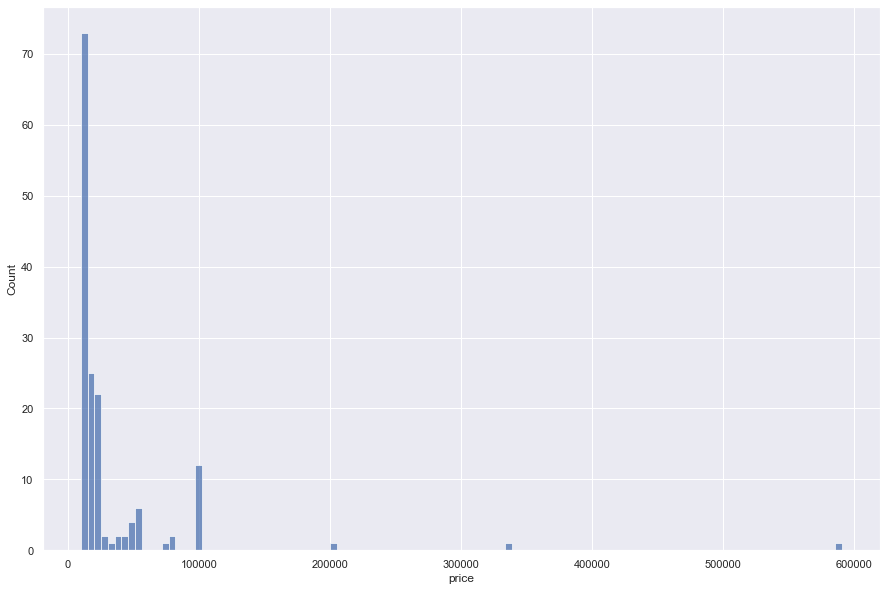

In [57]:
sns.histplot(data = df_subset[df_subset['price'] >= 10000], x = 'price')

In [58]:
# Looking into a sample of the listings
df_subset[df_subset['price'] >= 45000].head()

,id,host_id,host_total_listings_count,listing_url,last_scraped,source,name,description,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,zone
1331,2332585,11913750,1.0,https://www.airbnb.com/rooms/2332585,2022-09-22,city scrape,"Confortable, Well Placed, Nice View","Comfortable apartment, well located, with a wo...",santa teresa,Entire rental unit,Entire home/apt,4,1.0,1.0,2.0,"[Air conditioning, Essentials, Washer, Shampoo...",50000.0,50,Central
1603,2677829,7673499,5.0,https://www.airbnb.com/rooms/2677829,2022-09-22,city scrape,Apart Arpoador Well located- Best RJ Beaches,"It is a cozy apartment, very well located a fe...",ipanema,Entire rental unit,Entire home/apt,6,1.0,2.0,3.0,"[Iron, Essentials, Washer, Microwave, Kitchen,...",50000.0,2,South
3228,7695145,40415426,1.0,https://www.airbnb.com/rooms/7695145,2022-09-22,city scrape,q,xxxxx,tijuca,Private room in rental unit,Private room,2,2.0,1.0,2.0,"[Washer, Wifi, Long term stays allowed, Kitche...",100000.0,1,North
3273,8596751,38555079,1.0,https://www.airbnb.com/rooms/8596751,2022-09-21,city scrape,Tudo Super Bacana pra Voltar Sempre,Quarto confortável e privativo. Os melhores so...,curicica,Private room in rental unit,Private room,1,1.0,1.0,1.0,"[Cable TV, Heating, Air conditioning, Hangers,...",74111.0,2,West
3846,9952483,51144125,5.0,https://www.airbnb.com/rooms/9952483,2022-09-22,city scrape,"Suite Balcony, breezy, sunny morning.",I love the view to the green. Transport at the...,anil,Private room in rental unit,Private room,2,1.0,1.0,1.0,"[Hangers, Dedicated workspace, Lock on bedroom...",335103.0,1,West


Looking into the data, it looks like some listings are effectively high-end listings. That is not the case for all listings.\
Let's see how the max looks like if we propose quantile cuts to the data.

In [59]:
percentile_ranges = [.75,.8,.85,.9,.95,.99,.995]

percentile_values = np.quantile(df_subset['price'], percentile_ranges)

percentile_dict = {k:v for k, v in zip(percentile_ranges, percentile_values)}

In [60]:
percentile_dict

{0.75: 629.0,
 0.8: 773.0,
 0.85: 996.3500000000022,
 0.9: 1300.0,
 0.95: 2078.0,
 0.99: 7000.0,
 0.995: 10334.0}

If we cut as little as 0.5% of the data on the top end, we might land on a more feasible region for price distribution without having to worry about the extreme prices.

In [61]:
df_subset[df_subset['price']<=percentile_dict[0.995]]['price'].describe()

count    24694.000000
mean       609.119786
std        950.837286
min         33.000000
25%        190.000000
50%        319.000000
75%        614.000000
max      10334.000000
Name: price, dtype: float64

## 0 Values

In [62]:
df_subset[df_subset['price'] == 0]

,id,host_id,host_total_listings_count,listing_url,last_scraped,source,name,description,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,zone


They look like mistakes. When checking the listing's URL, they have a price.\
For simplicity these will be removed

In [63]:
df_subset = df_subset[df_subset['price'] > 0].copy()

## Plotting the resulting distribution

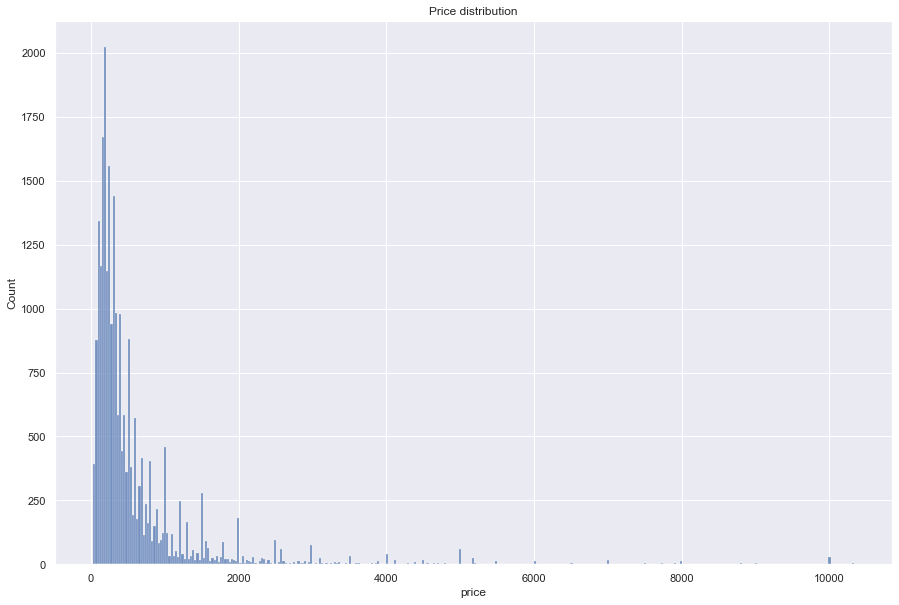

In [64]:
fig, ax = plt.subplots()

sns.histplot(data = df_subset[df_subset['price'] <= percentile_dict[0.995]], x = 'price', ax = ax)

ax.set_title('Price distribution')

plt.show()

Price is a right-skewed distribution.\
This is expected, since the amount of goods (listings in this case) tend to be higher towards lower price ranges since these ranges are more affordable.

It's clearly not normally distributed. 

In [65]:
# Filtering the data to remove extreme values
df_subset = df_subset[df_subset['price'] <= percentile_dict[0.995]].copy()

# Where are the cheapest listings?

## City Zones

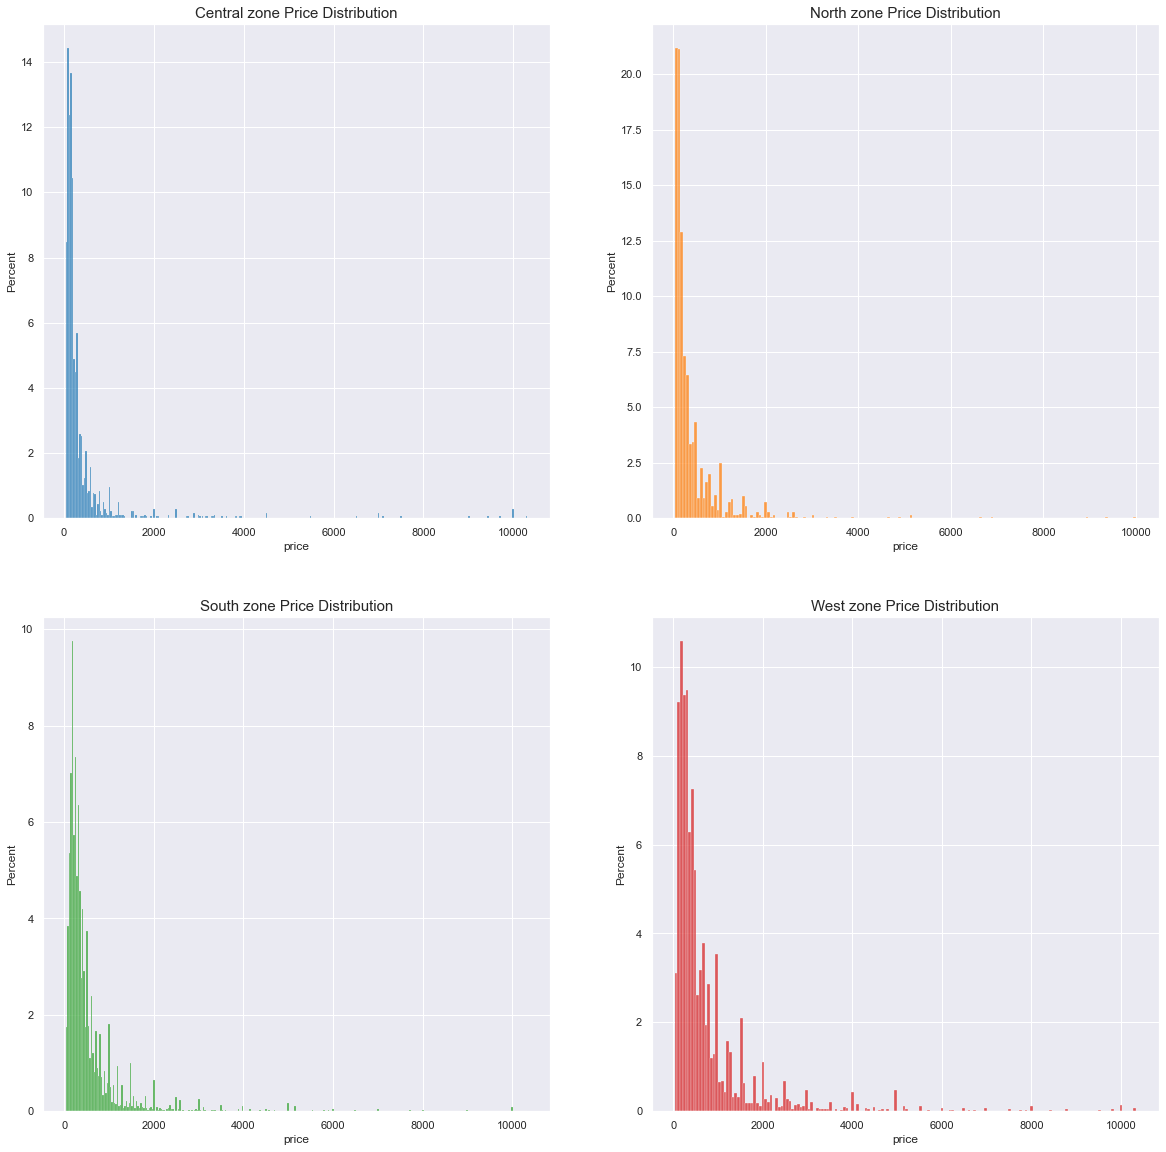

In [95]:
# Are price distributions different across zones?

fig, axs = plt.subplots(2,2, figsize = (20,20))

axs = axs.flatten()

for i, (zone, color) in enumerate([('Central','tab:blue'),('North','tab:orange'),('South','tab:green'),('West','tab:red')]):

    sns.histplot(data = df_subset.loc[df_subset['zone'] == zone,['price']],
                    x = 'price',
                    ax = axs[i],
                    color = color,
                    stat = 'percent')

    axs[i].set_title(f'{zone} zone Price Distribution', fontsize = 15)

plt.show()

In [66]:
# Using median and mean as statistics since distribution is skewed
agg_zones = df_subset.groupby('zone', as_index = False).agg({'price':['mean','median']})

In [67]:
agg_zones.columns = ['zone','mean','median']

In [68]:
agg_zones

,zone,mean,median
0,Central,397.322472,180.0
1,North,412.487909,190.0
2,South,568.492969,315.0
3,West,786.673714,400.0


In [101]:
agg_zones[['zone','median']]\
        .rename(columns = {'zone':'Zone','median':'Median'})\
        .style.background_gradient(subset = 'Median')

,Zone,Median
0,Central,180.000000
1,North,190.000000
2,South,315.000000
3,West,400.000000


## Neighbourhoods

In [125]:
agg_neighbourhoods = df_subset.groupby(['neighbourhood_cleansed','zone'], as_index = False)['price'].agg(['median','size'])

In [126]:
agg_neighbourhoods.reset_index()

,neighbourhood_cleansed,zone,median,size
0,abolicao,North,189.5,4
1,acari,North,250.0,1
2,agua santa,North,180.0,3
3,alto da boa vista,North,498.0,34
4,anchieta,North,2720.0,2
...,...,...,...,...
149,vila kosmos,North,64.0,1
150,vila militar,West,145.0,1
151,vila valqueire,West,456.0,16
152,vista alegre,North,100.0,1


In [131]:
agg_neighbourhoods[agg_neighbourhoods['size'] > 30]\
                    .groupby('zone')['median']\
                    .nsmallest(5)\
                    .droplevel(-1)\
                    .to_frame()\
                    .rename(columns = {'median':'Median'})
                    # .index.rename({'zone':'Zone','neighbourhood_cleansed':'Neighbourhood'})

Median
zone    neighbourhood_cleansed        
Central centro                   165.0
        estacio                  180.0
        santa teresa             180.0
        rio comprido             200.0
        sao cristovao            200.0
North   engenho novo              99.0
        jardim guanabara         164.5
        grajau                   172.5
        vila isabel              180.0
        andarai                  195.0
South   gloria                   188.0
        vidigal                  200.0
        flamengo                 220.0
        botafogo                 228.0
        catete                   238.5
West    campo grande             200.0
        pechincha                209.0
        taquara                  230.0
        anil                     250.0
        curicica                 250.0

Here, we have a list of neighbourhoods per zone that have the cheapest listings on average

# Can we segment listings by the collection of their characteristics?

Using K-Modes to find general group of listings.

In [133]:
# Variable that describe a listing directly
# Not considering ammenities for simplicity
listing_vars = ['property_type',
                'room_type',
                'accommodates',
                'bathrooms_text',
                'bedrooms',
                'beds',
                'minimum_nights']

## Exploration of variables

In [134]:
df_subset[listing_vars].describe(include = [np.number, object])

,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,minimum_nights
count,24694,24694,24694.000000,24694.000000,24694.000000,24694.000000,24694.000000
unique,83,4,NaN,NaN,NaN,NaN,NaN
top,Entire rental unit,Entire home/apt,NaN,NaN,NaN,NaN,NaN
freq,13866,18781,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,4.167328,1.643314,1.682473,2.627561,4.965498
std,NaN,NaN,2.442226,1.025992,1.069475,2.253717,25.125126
min,NaN,NaN,1.000000,0.000000,1.000000,1.000000,1.000000
25%,NaN,NaN,2.000000,1.000000,1.000000,1.000000,1.000000
50%,NaN,NaN,4.000000,1.000000,1.000000,2.000000,2.000000
75%,NaN,NaN,5.000000,2.000000,2.000000,3.000000,4.000000


- Looks like it might be interesting to somehow reduce the property_type categories
- Some variables seem to have really weird extreme values, for instance a listing with 91 beds or 47 bathrooms
- We could treat the ```acommodates, bathrooms, bedrooms, beds and minimum nights``` as continuous columns. But it looks like there is some concentration that might favour treating them as categories

Let's try to find natural thresholds to group these variables by if we treat them as categorical

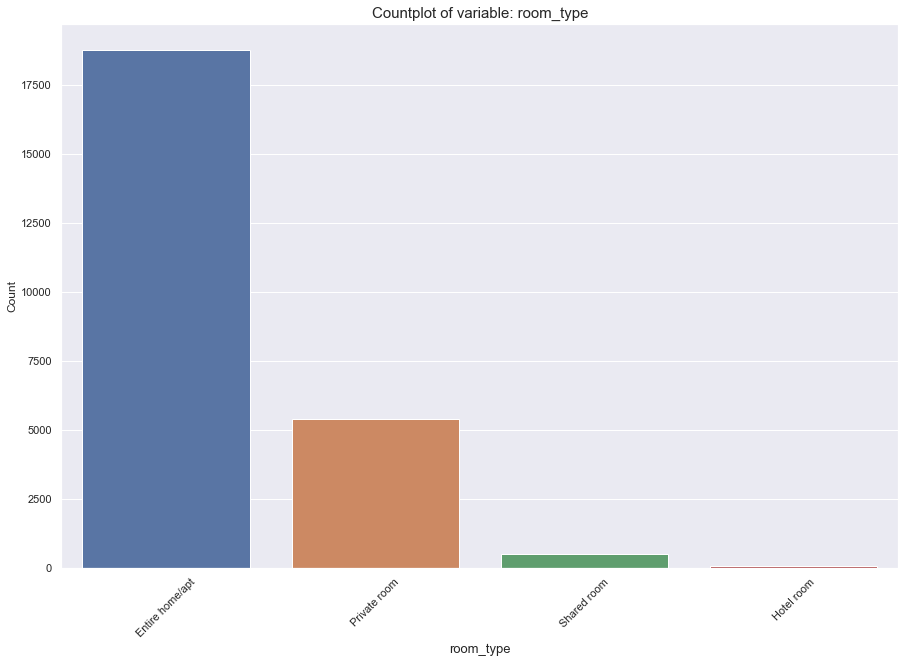

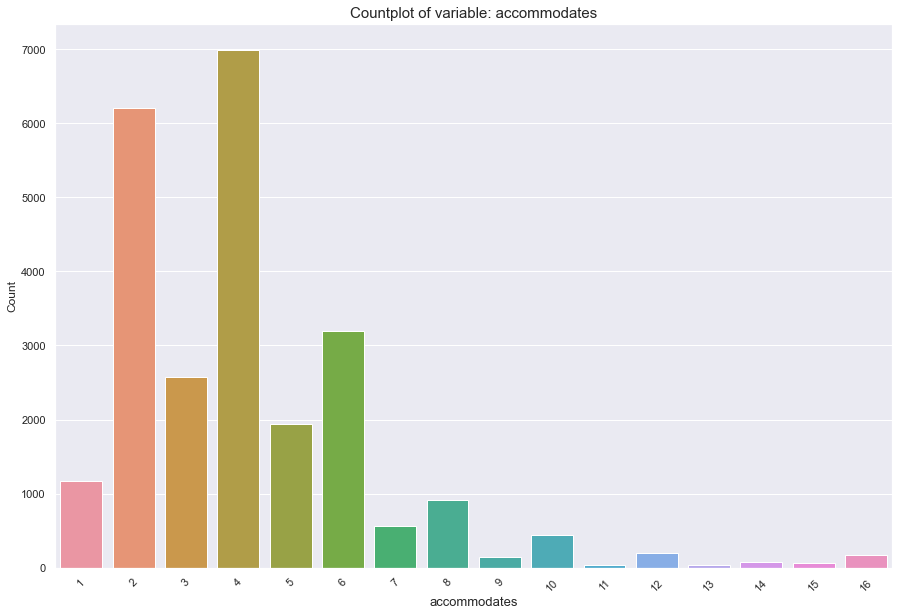

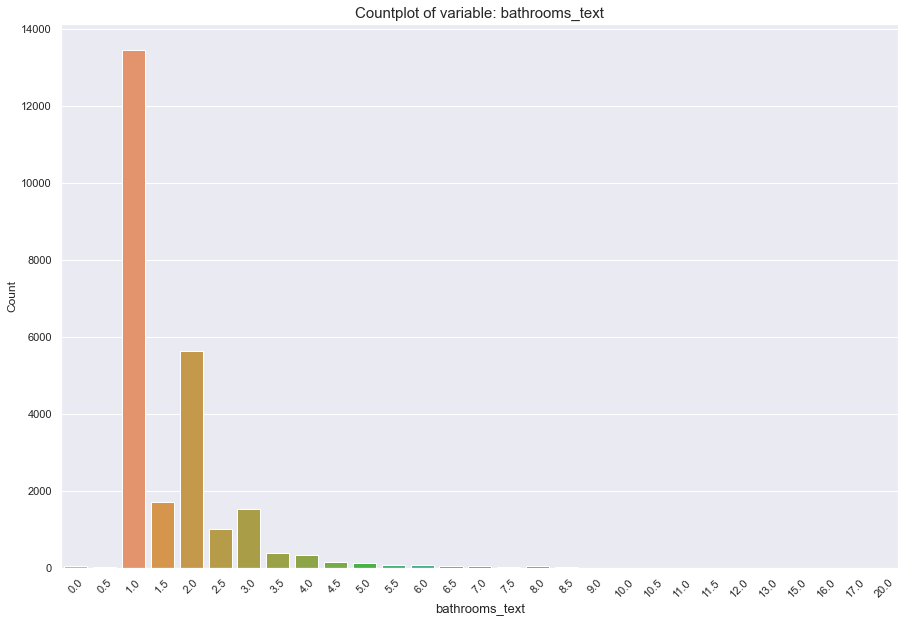

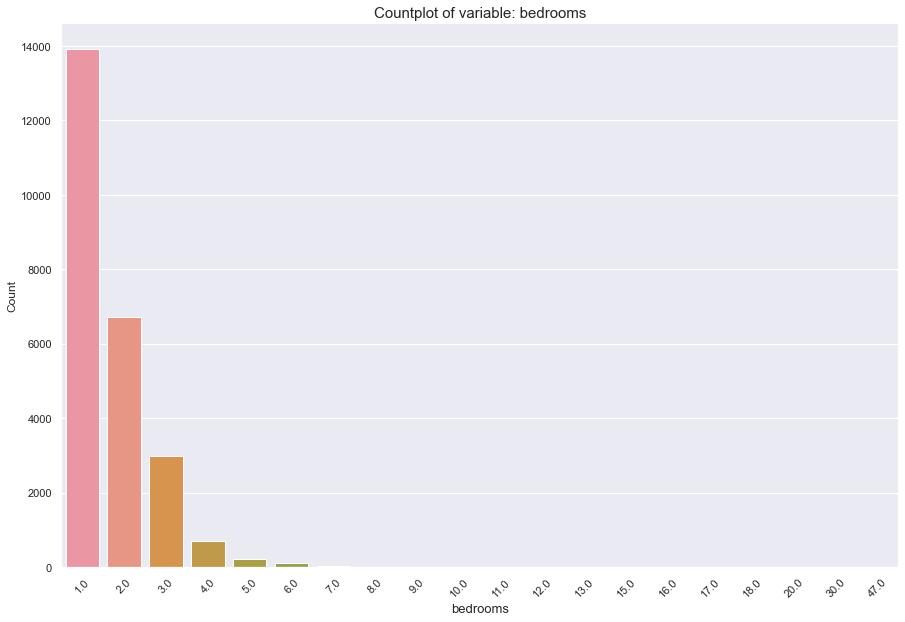

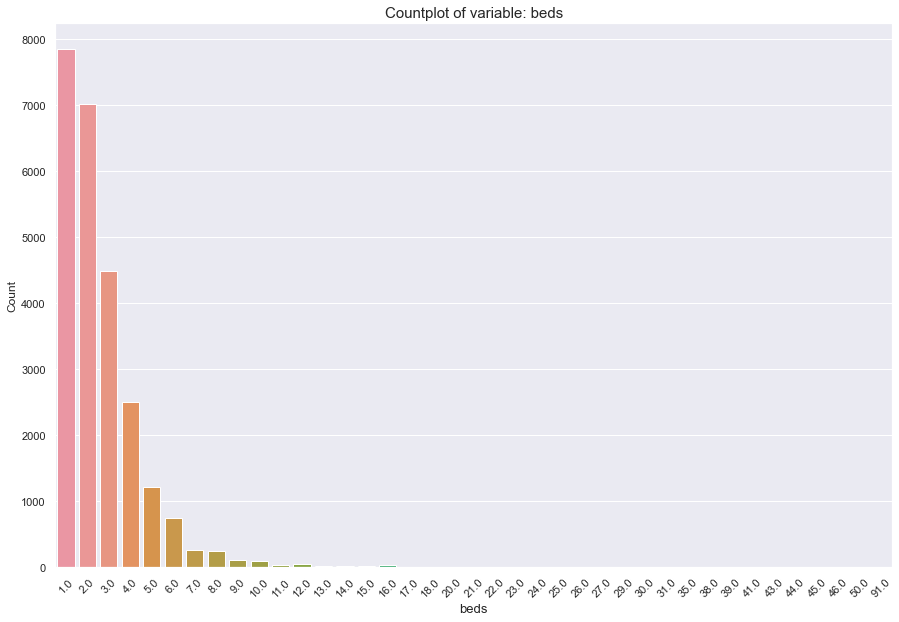

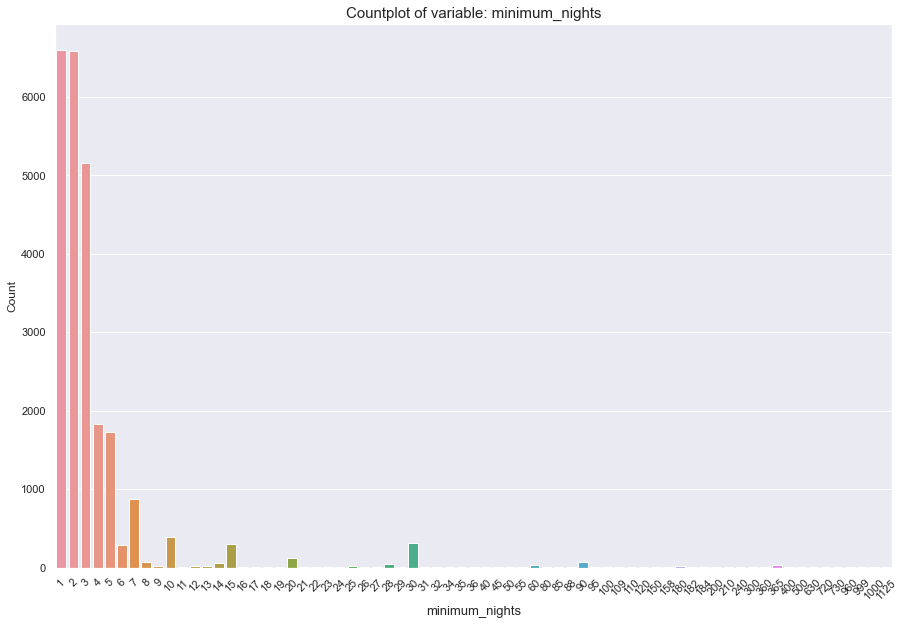

In [136]:
# Distribution by category
# Disconsidering property_type because of the amount of categories. Will be dealt with later
for col in listing_vars:

    if col == 'property_type':

        continue

    sns.countplot(data = df_subset, x = col)

    plt.title(f'Countplot of variable: {col}', fontdict={'fontsize':15})

    plt.xlabel(col, fontdict = {'fontsize':13})

    plt.ylabel('Count')

    plt.xticks(rotation = 45)

    plt.show()

From the graphs, some possible thresholds emerge:

- room_type &rarr; we could leave it as is for the time being. 4 categories (3 if we disconsider hotel room) is manageable
- acommodates &rarr; it looks like there are generally less listings that acommodate more than 6 people
- bathrooms &rarr; the majority of listings have up to 3 bathrooms
- bedrooms &rarr; the majority of listings have up to 3 bedrooms
- beds &rarr; Most listings have up to 6 beds
- minimum_nights &rarr; the vast majority of listings allow for a minimum of 7 nights. From that point on, it seems that date marks (10 days, two-weeks (15 days), one-month) have spikes for listings, but aren't many sparks  



## Variables Thresholding

In [137]:
# Setting thresholds
# Threshold for minimum_nights will be considered 7 for simplicity
var_threshold = {'accommodates':6,
                'bathrooms_text':3,
                'bedrooms':3,
                'beds':6,
                'minimum_nights':7}

In [138]:
# Setting thresholds
for col,thresh in var_threshold.items():

    df_subset[f'agg_{col}'] = np.where(df_subset[col] <= thresh, df_subset[col], f'more_than_{thresh}')

## Property Type Aggregation

In [139]:
# Looking into property type - Proportion of each class
df_subset['property_type'].value_counts(normalize = True).head(10)

Entire rental unit                   0.561513
Private room in rental unit          0.123471
Entire condo                         0.077671
Entire home                          0.044383
Private room in home                 0.039119
Entire serviced apartment            0.032640
Entire loft                          0.023933
Private room in condo                0.018304
Shared room in rental unit           0.006641
Private room in bed and breakfast    0.006155
Name: property_type, dtype: float64

In [140]:
# Looking into property type - Cumulative proportion
df_subset['property_type'].value_counts(normalize = True).cumsum().head(10)

Entire rental unit                   0.561513
Private room in rental unit          0.684984
Entire condo                         0.762655
Entire home                          0.807038
Private room in home                 0.846157
Entire serviced apartment            0.878796
Entire loft                          0.902729
Private room in condo                0.921033
Shared room in rental unit           0.927675
Private room in bed and breakfast    0.933830
Name: property_type, dtype: float64

Only the categories that represent more than 1% of transactions will be kept. This means that we'll keep the categories up to 'Private room in condo'.

In [141]:
prop_type_to_keep = df_subset['property_type'].value_counts(normalize = True) >= 0.01

prop_type_to_keep = prop_type_to_keep[prop_type_to_keep == True].index.to_list()

In [142]:
df_subset['agg_property_type'] = np.where(df_subset['property_type'].isin(prop_type_to_keep), df_subset['property_type'], 'other')

In [143]:
df_subset['agg_property_type'].value_counts(dropna = False, normalize = True)

Entire rental unit             0.561513
Private room in rental unit    0.123471
other                          0.078967
Entire condo                   0.077671
Entire home                    0.044383
Private room in home           0.039119
Entire serviced apartment      0.032640
Entire loft                    0.023933
Private room in condo          0.018304
Name: agg_property_type, dtype: float64

## Clustering

In [144]:
cluster_cols = ['room_type'] + [col for col in df_subset.columns if col.startswith('agg')]

In [145]:
cluster_cols

['room_type',
 'agg_accommodates',
 'agg_bathrooms_text',
 'agg_bedrooms',
 'agg_beds',
 'agg_minimum_nights',
 'agg_property_type']

In [146]:
n_clusters = [2,3,4,5,6,7,8,9,10]

In [147]:
# Training the model
for i, n in enumerate(n_clusters):

    km = KModes(n_clusters=n, init='Cao', n_jobs = -1, random_state = 123)

    km.fit(df_subset[cluster_cols].values)

    if i == 0:

        cost_list = [km.cost_]

    else:

        cost_list.append(km.cost_)

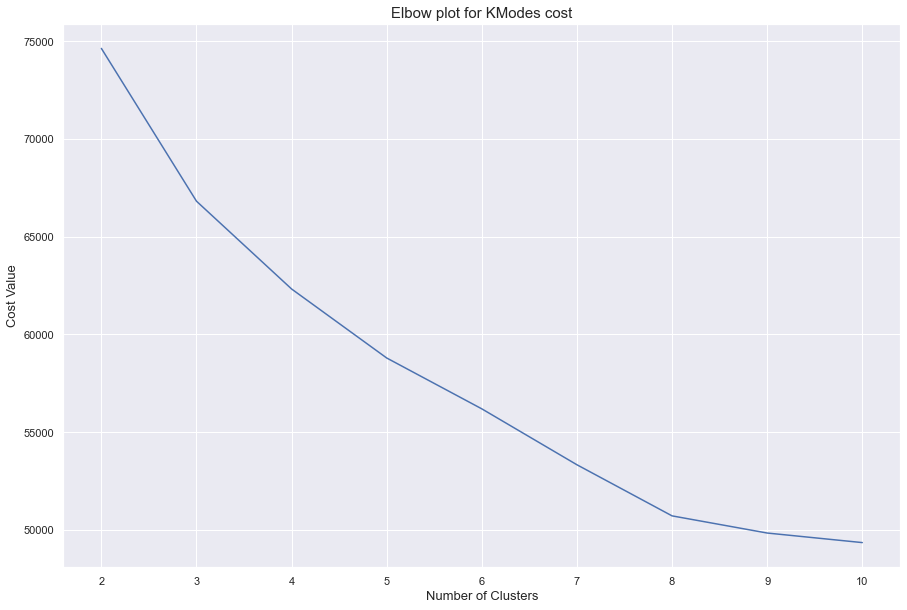

In [149]:
# Elbow plot
sns.lineplot(x = n_clusters, y = cost_list)

plt.title('Elbow plot for KModes cost', fontsize = 15)

plt.xlabel('Number of Clusters', fontdict={'fontsize':13})

plt.ylabel('Cost Value', fontdict={'fontsize':13})

plt.show()

Using the elbow method, n = 8 looks like a good number for clusters

In [150]:
km = KModes(n_clusters= 8, init='Cao', n_jobs = -1, random_state = 123)

km.fit(df_subset[listing_vars].values)

df_subset['cluster'] = km.labels_

In [151]:
pd.DataFrame(km.cluster_centroids_, columns = listing_vars)

,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,minimum_nights
0,Entire rental unit,Entire home/apt,4,1.0,1.0,1.0,1
1,Entire rental unit,Entire home/apt,4,2.0,2.0,2.0,2
2,Private room in rental unit,Private room,2,1.0,1.0,1.0,1
3,Entire condo,Entire home/apt,6,1.0,2.0,3.0,3
4,Entire rental unit,Entire home/apt,6,2.0,3.0,3.0,3
5,Entire rental unit,Entire home/apt,3,1.0,1.0,2.0,2
6,Entire rental unit,Entire home/apt,6,3.0,3.0,4.0,2
7,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,2


The clusters seem to work nicely.  
It is possible to see that the majority of clusters are centered around entire rental units an homes and apartments. This is expected since they are classes that dominate the dataset.  
But, looking into the acomodation capacity and the other variables, we can spot the differences between clusters

This result confirms our hypothesis that we can use features to group similar listings.

## Price per cluster

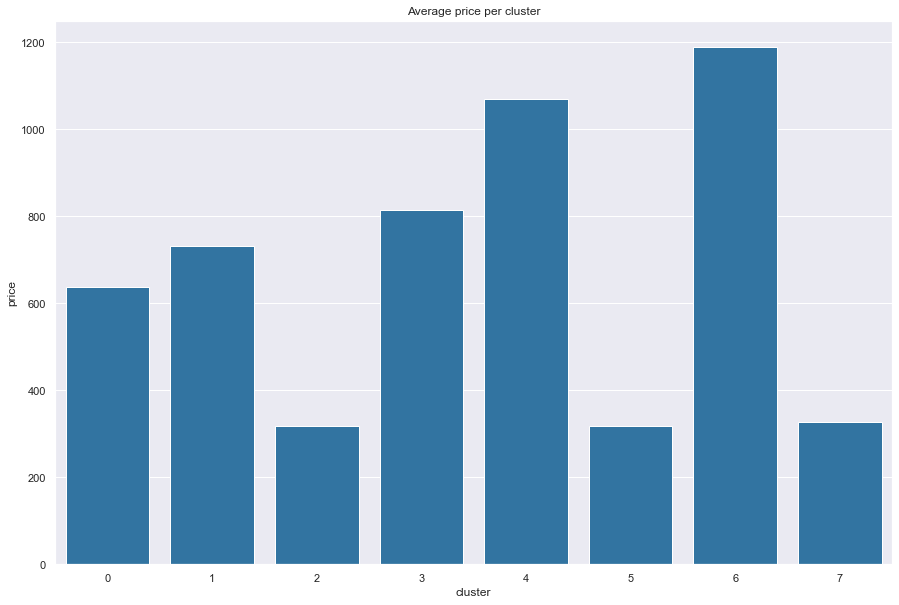

In [152]:
avg_price_per_cluster = df_subset.groupby('cluster')['price'].mean()

sns.barplot(x = avg_price_per_cluster.index, y = avg_price_per_cluster, color = 'tab:blue')

plt.title('Average price per cluster')

plt.show()

The prices seem adherent to the clusters' descriptions.\
Clusters with smaller listings that accomodate less people charge on average less then clusters that accomodate more users and have a higher number of features (beds, baths, ...)  
This information further validates the approach

# Is market concentration related to price?

Does owning multiple have a relationship to how prices behave somehow? 

If this affects prices, this could affect our findings on the previous questions

We can look at it in a couple of ways from the data we have at hand:
- By clusters
- We can look by zones and neighbourhoods
- We correlate that directly on the data looking to the host_listings and price columns


In [200]:
def get_host_aggregates(data = df_subset, group_col = None):

    # Aggregating data
    aggregate = data.groupby(group_col)\
                        .agg({'host_id':'nunique','id':'count','price':['mean','std','median']})

    # Removing multiindex
    aggregate.columns = [f'{x}_{y}' for x, y in aggregate.columns]

    # Fetching the zones for plot
    aggregate.reset_index(drop = False, inplace = True)

    # Getting avg listings by host - Market Concentration metric
    aggregate['listings_by_host'] = aggregate['id_count'] / aggregate['host_id_nunique']

    return aggregate

def plot_agg_comparison(data, var):

    fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize = (20,15),sharex = True)

    sns.pointplot(data = data, x = var, y = 'price_mean', ax = ax1, color='tab:blue')

    ax1.set_ylabel('Price Mean')

    ax1.set_xlabel('')

    ax1.set_title(f'Aggregate indicators by {var}', fontdict = {'fontsize':15})

    sns.pointplot(data = data, x = var, y = 'price_median', ax = ax2, color = 'tab:orange')

    ax2.set_ylabel('Price Median')

    ax2.set_xlabel('')

    sns.pointplot(data = data, x = var, y = 'listings_by_host', ax = ax3, color = 'tab:green')

    ax3.set_ylabel('Average Listings by Host')

    ax3.set_xlabel(var, fontdict={'fontsize':13})

    plt.show()

## Clusters
Do hosts that put up similar listings charge more?\
If concentration has anything to do with the price difference from the clusters, we should see at least a correlation between market concentration and prices, especially for similar clusters.

In [201]:
aggs_by_cluster = get_host_aggregates(group_col = 'cluster')

In [202]:
aggs_by_cluster

,cluster,host_id_nunique,id_count,price_mean,price_std,price_median,listings_by_host
0,0,3940,5671,637.171222,1190.655984,288.0,1.439340
1,1,4098,5112,732.012128,851.692538,490.0,1.247438
2,2,3411,4928,318.253044,600.651051,184.0,1.444738
3,3,1059,1240,813.757258,1142.661808,420.0,1.170916
4,4,1670,2193,1068.904697,1147.719429,700.0,1.313174
5,5,2045,2492,318.126003,452.594265,235.0,1.218582
6,6,972,1126,1190.103020,1230.094750,774.0,1.158436
7,7,1555,1932,327.026915,410.218069,230.0,1.242444


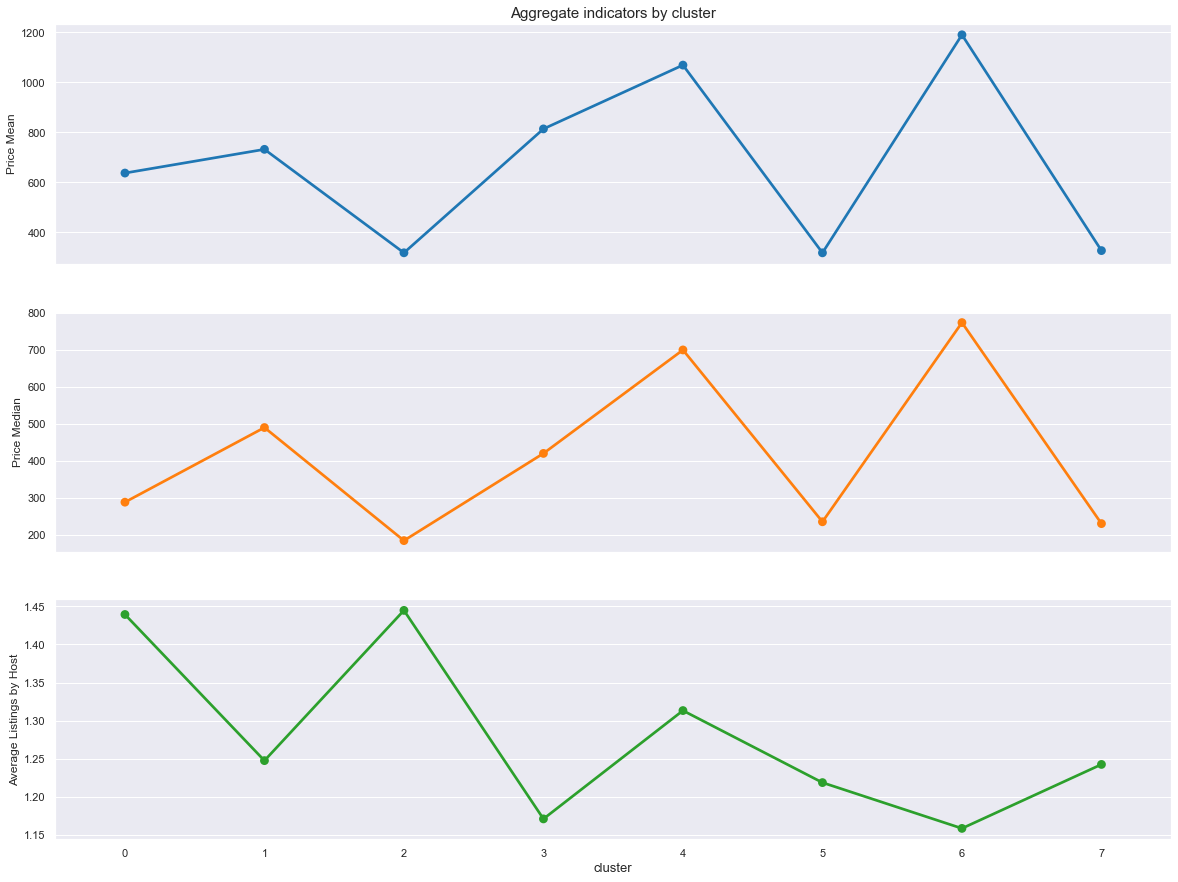

In [203]:
plot_agg_comparison(aggs_by_cluster,'cluster')

Clusters 0,2 and 4 and clusters 1,3 are relatively similar. If concentration has some relation to price, we should see differences between each of the clusters, since concentration is so different between them.\
As it looks, however, there is no sort of correlation between market-concentration and the price charged by cluster.

## Geographical Lens
Looking into market concentration geographically

### Zones

In [204]:
aggs_by_zone = get_host_aggregates(group_col = 'zone')

In [205]:
aggs_by_zone

,zone,host_id_nunique,id_count,price_mean,price_std,price_median,listings_by_host
0,Central,1308,1780,397.322472,922.338267,180.0,1.360856
1,North,1120,1406,412.487909,716.977477,190.0,1.255357
2,South,8842,14508,568.492969,847.999607,315.0,1.640805
3,West,5043,7000,786.673714,1151.367770,400.0,1.388063


There are a lot more listings on the south zone of the city.\
This is expected behaviour, since it's the predominant zone for tourist attractions

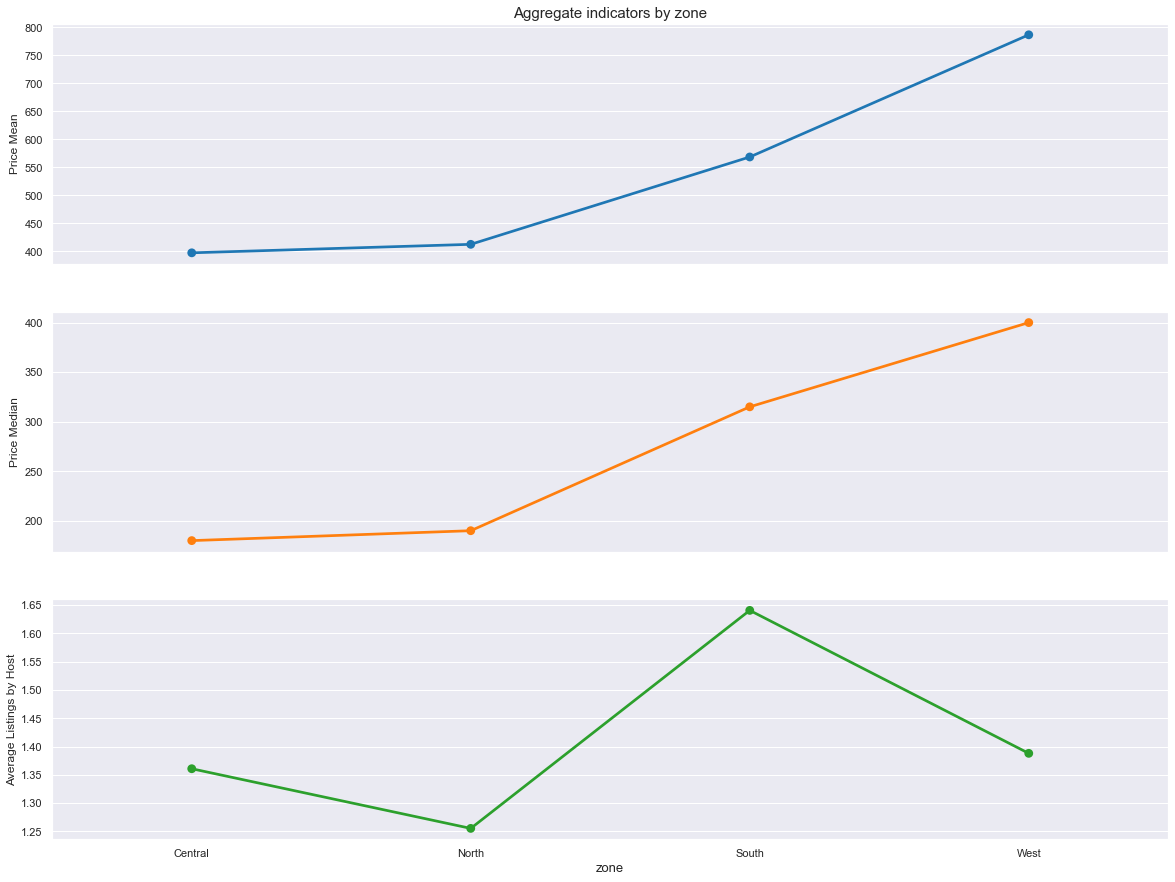

In [206]:
plot_agg_comparison(aggs_by_zone,'zone')

Looking at the data through the Zoning lens, it doesn't looks like Zones that have more average listings by host (i.e. more concentrated markets) necessairly will result in higher prices

### Neighborhoods

In [207]:
aggs_by_neighbourhoods = get_host_aggregates(group_col = ['neighbourhood_cleansed','zone'])

In [208]:
# Getting only neighbourhoods with a good sample size
aggs_by_neighbourhoods = aggs_by_neighbourhoods[aggs_by_neighbourhoods['id_count'] >= 30]

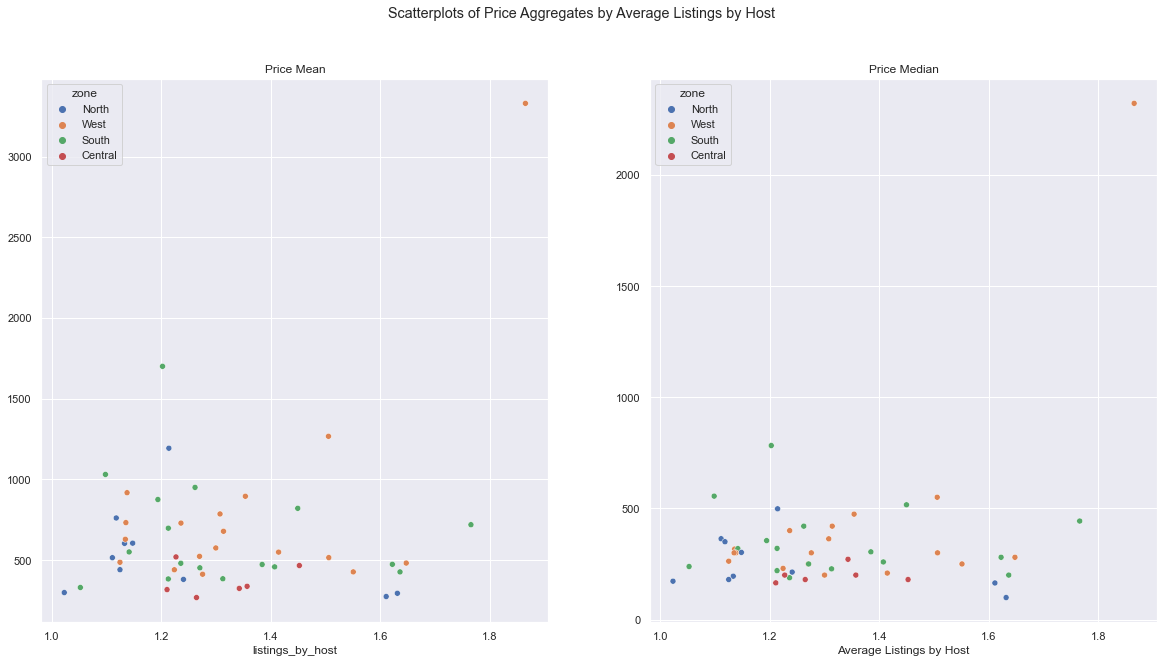

In [209]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10),sharex = True)

sns.scatterplot(data = aggs_by_neighbourhoods, x = 'listings_by_host', y = 'price_mean',hue = 'zone',ax = ax1)

ax1.set_title('Price Mean')

ax1.set_ylabel('')

ax2.set_xlabel('Average Listings by Host')

sns.scatterplot(data = aggs_by_neighbourhoods, x = 'listings_by_host', y = 'price_median',hue = 'zone',ax = ax2)

ax2.set_title('Price Median')

ax2.set_ylabel('')

ax2.set_xlabel('Average Listings by Host')

plt.suptitle('Scatterplots of Price Aggregates by Average Listings by Host')

plt.show()

Even breaking down at the neighbourhood level, no evident pattern arises

## Directly from Data

In [210]:
agg_host = df_subset.groupby('host_id').agg({'host_total_listings_count':'unique', 'price':'mean'})

# Getting rid of Arrays
agg_host = agg_host.explode('host_total_listings_count')

# Type fix
agg_host['host_total_listings_count'] = agg_host['host_total_listings_count'].astype(float)

# We are only interested in hosts with more than 1 listing
agg_host = agg_host[agg_host['host_total_listings_count'] > 1]

In [211]:
print('Pearson Correlation')
display(agg_host.corr('pearson'))

print('Spearman Correlation')
display(agg_host.corr('spearman'))

Pearson Correlation


,host_total_listings_count,price
host_total_listings_count,1.000000,0.037343
price,0.037343,1.000000


Spearman Correlation


,host_total_listings_count,price
host_total_listings_count,1.000000,0.001714
price,0.001714,1.000000


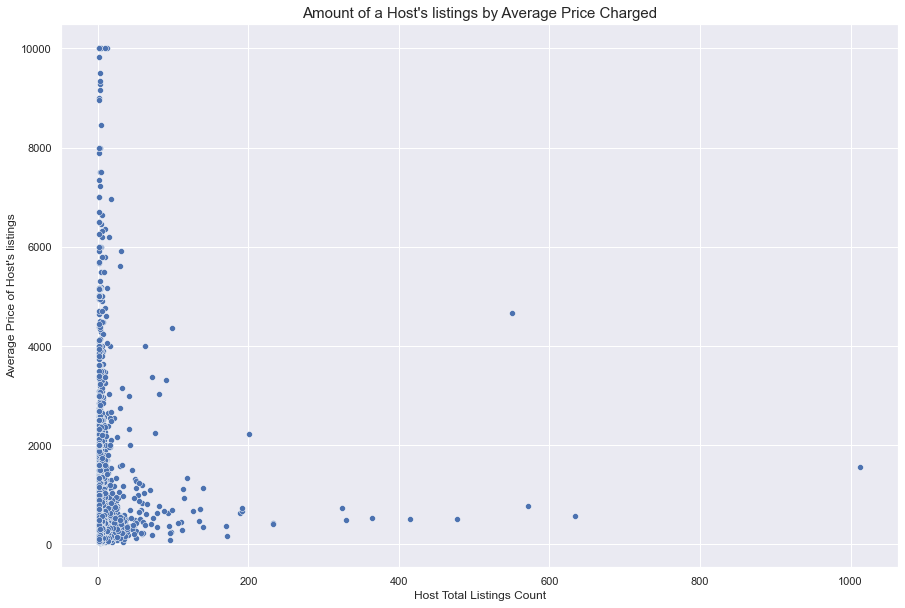

In [212]:
sns.scatterplot(data = agg_host, x = 'host_total_listings_count', y = 'price')

plt.xlabel('Host Total Listings Count')

plt.ylabel("Average Price of Host's listings")

plt.title("Amount of a Host's listings by Average Price Charged", fontdict={'fontsize':15})

plt.show()

Even by trying to correlate the data directly, there seems to be no evidence that links the number of listings from a user to the price charged by that host.

General conclusion:

Prices in Rio's AirBnB listings do not seem to have a correlation with market concentration

# What are "Standard Amenities" a customer should expect from a listing?

Let's create a quick corpus for our data and see if we can keep only some key amenities or come up with other fixes.\
I'm specially interested in the Wifi amenity that contains internet speed. Wifi available or not should be counted regardless of speed. This, of course, excluding specific cases such as well-equipped, remote-work ready AirBnBs

In [153]:
amenities_corpus = df_subset['amenities'].explode()

In [154]:
print('Unique Amenities: ',amenities_corpus.nunique())

Unique Amenities:  3132


In [155]:
# Looking specifically into wifi
len(amenities_corpus[amenities_corpus.str.contains('wifi', case = False)].unique())

395

In [156]:
# Samples
amenities_corpus[amenities_corpus.str.contains('wifi', case = False)].unique()[0:10]

array(['Wifi', 'Wifi 30 Mbps', 'Pocket wifi', 'Wifi 28 Mbps',
       'Fast wifi 663 Mbps', 'Fast wifi 55 Mbps', 'Fast wifi 157 Mbps',
       'Fast wifi 66 Mbps', 'Fast wifi 542 Mbps', 'Fast wifi 413 Mbps'],
      dtype=object)

There are a lot of possible entries for wifi, we'll replace them all for simplicity.\
Will do it in two categories: Fast and Regular Wifi

In [157]:
reg_wifi_pat = r'(?<!Fast\s)wifi'

fast_wifi_pat = r'(?<=Fast\s)wifi'

In [158]:
reg_wifi_repl_str = '|'.join(amenities_corpus[amenities_corpus.str.contains(reg_wifi_pat, case = False)].unique())

fast_wifi_repl_str = '|'.join(amenities_corpus[amenities_corpus.str.contains(fast_wifi_pat, case = False)].unique())

In [159]:
amenities_corpus = amenities_corpus.str.replace(reg_wifi_repl_str,'Wifi', regex = True)\
                                    .str.replace(fast_wifi_repl_str,'Fast Wifi', regex = True)

In [160]:
print('Unique Amenities: ',amenities_corpus.nunique())

Unique Amenities:  2788


### Obtaining the most usual amenities

The most frequent amenities are those that are present in a big part of the listings. The total count of an amenity means the amount of appearances of that amenity on listings

In [161]:
amenities_pareto = amenities_corpus.value_counts().to_frame()

In [162]:
amenities_pareto.rename(columns = {'amenities':'listings_count'}, inplace = True)

In [163]:
# Getting proportion of amenities in listings
amenities_pareto['listings_proportion'] = amenities_pareto['listings_count'] / df_subset.shape[0]

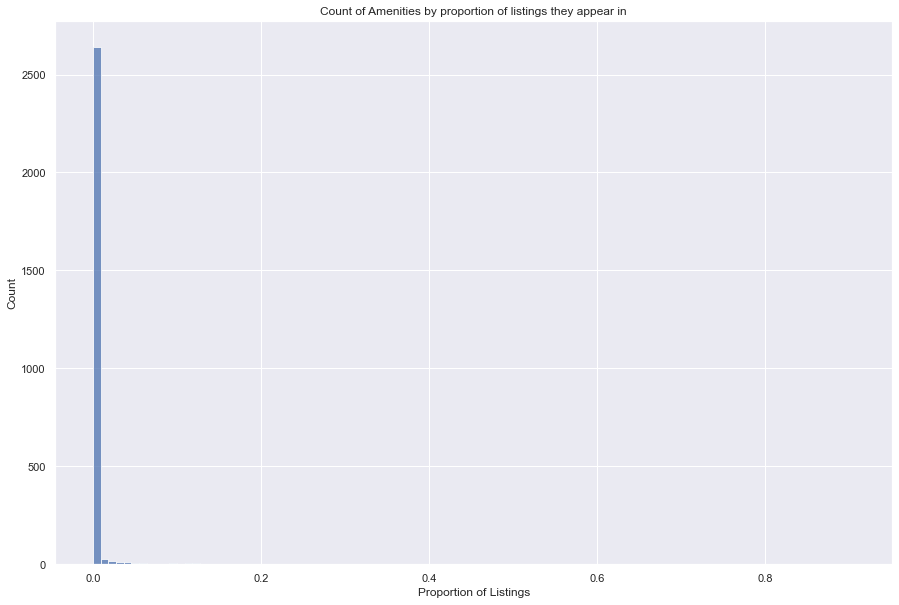

In [164]:
sns.histplot(data = amenities_pareto, x = 'listings_proportion', bins = 100)

plt.title('Count of Amenities by proportion of listings they appear in')

plt.xlabel('Proportion of Listings')

plt.show()

In [173]:
shape_vals = []

prop_vals = []

for proportion in np.arange(0,1.1,.1):

    prop_vals.append(round(proportion,1))

    shape_val = amenities_pareto[amenities_pareto['listings_proportion'] >= proportion].shape[0]

    shape_vals.append(shape_val)

    print(f'Amount of amenities that occur in at least {proportion:.2%} of all listings:', shape_val)
    

Amount of amenities that occur in at least 0.00% of all listings: 2788
Amount of amenities that occur in at least 10.00% of all listings: 56
Amount of amenities that occur in at least 20.00% of all listings: 34
Amount of amenities that occur in at least 30.00% of all listings: 23
Amount of amenities that occur in at least 40.00% of all listings: 18
Amount of amenities that occur in at least 50.00% of all listings: 13
Amount of amenities that occur in at least 60.00% of all listings: 9
Amount of amenities that occur in at least 70.00% of all listings: 4
Amount of amenities that occur in at least 80.00% of all listings: 3
Amount of amenities that occur in at least 90.00% of all listings: 2
Amount of amenities that occur in at least 100.00% of all listings: 0


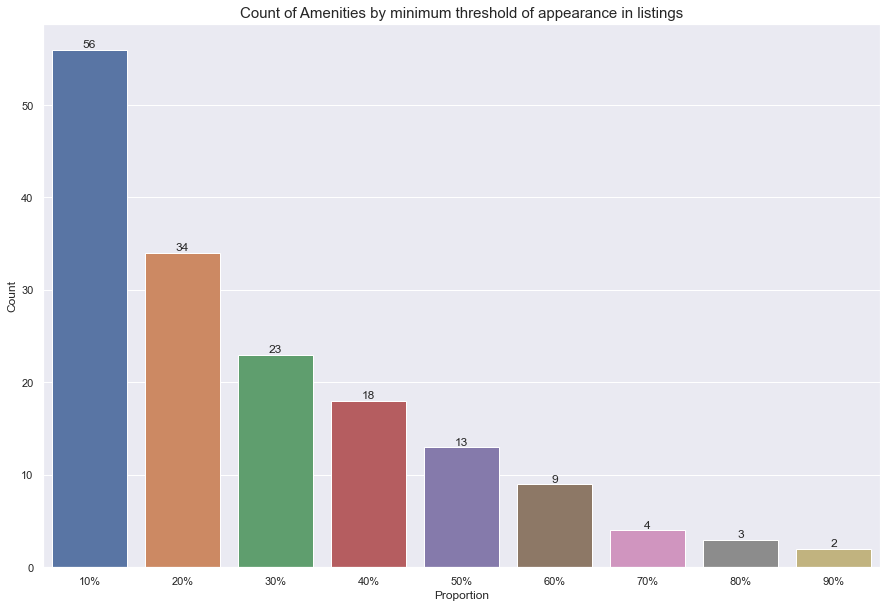

In [187]:
# Plot without 0% and 100%

ax = sns.barplot(x= prop_vals[1:-1], y = shape_vals[1:-1])

ax.set_title('Count of Amenities by minimum threshold of appearance in listings', fontsize = 15)

ax.set_ylabel('Count')

ax.set_xlabel('Proportion')

ax.bar_label(ax.containers[-1])

ax.set_xticklabels([f'{x:.0%}' for x in prop_vals[1:-1]])

plt.show()

1. There might be a lot of unique values because of an open format of the field. 
2. Of all the possible amenities, only 13 appear on more than half of the listings. If we make a cut as small as 10% we can already indetify a relevant subset of amenities

In [194]:
display(amenities_pareto[amenities_pareto['listings_proportion'] >= 0.1]\
                            .nlargest(10, columns='listings_count')\
                            .style\
                            .background_gradient(subset = 'listings_proportion')\
                            .format({'listings_proportion':'{:.2%}'}))

display(amenities_pareto[amenities_pareto['listings_proportion'] >= 0.1]\
                    .nsmallest(10, columns='listings_count')\
                    .sort_values('listings_proportion', ascending = False)\
                    .style\
                    .background_gradient(subset = 'listings_proportion')\
                    .format({'listings_proportion':'{:.2%}'}))

,listings_count,listings_proportion
Wifi,22384,90.65%
Kitchen,22290,90.26%
Long term stays allowed,21684,87.81%
Essentials,18851,76.34%
Hangers,15969,64.67%
Iron,15460,62.61%
Hot water,15235,61.70%
Dishes and silverware,15095,61.13%
Air conditioning,15071,61.03%
Elevator,14006,56.72%


,listings_count,listings_proportion
BBQ grill,3168,12.83%
Toaster,3067,12.42%
Security cameras on property,3057,12.38%
Free washer In unit,3022,12.24%
Portable fans,2919,11.82%
Window AC unit,2867,11.61%
Dryer,2825,11.44%
Gym,2817,11.41%
Private patio or balcony,2705,10.95%
Beachfront,2692,10.90%
